# Face Recognition Model
Model based on ideas of papers DeepFace and FaceNet
Face recognition problems commonly fall into two categories:

1. Face Verification - "is this the claimed person?". For example, at some airports, you can pass through customs by letting a system scan your passport and then verifying that you (the person carrying the passport) are the correct person. A mobile phone that unlocks using your face is also using face verification. This is a 1:1 matching problem.
2. Face Recognition - "who is this person?".Employees entering the office without needing to otherwise identify themselves. This is a 1:K matching problem.
FaceNet learns a neural network that encodes a face image into a vector of 128 numbers. By comparing two such vectors, you can then determine if two pictures are of the same person.

In this project we will-
- Implement the triplet loss function
- Use a pretrained model to map face images into 128-dimensional encodings
- Use these encodings to perform face verification and face recognition
In this we will be using a pre-trained model of deep inception model which represents ConvNet activations using a "channels first" convention, as opposed to the "channels last" convention generally used . In other words, a batch of images will be of shape $(m, n_C, n_H, n_W)$ instead of $(m, n_H, n_W, n_C)$. Both of these conventions have a reasonable amount of traction among open-source implementations; there isn't a uniform standard yet within the deep learning community.

Let's load the required packages.

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks_v2 import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=np.nan)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Naive face verification
In Face Verification, we're given two images and we have to tell if they are of the same person. The simplest way to do this is to compare the two images pixel-by-pixel. If the distance between the raw images are less than a chosen threshold, it may be the same person!                                                                     
Of course, this algorithm performs really poorly, since the pixel values change dramatically due to variations in lighting, orientation of the person's face, even minor changes in head position, and so on.
We'll see that rather than using the raw image, we can learn an encoding $f(img)$ so that element-wise comparisons of this encoding gives more accurate judgements as to whether two pictures are of the same person.
#  Encoding face images into a 128-dimensional vector
##  Using an ConvNet to compute encodings
The FaceNet model takes a lot of data and a long time to train. So following common practice in applied deep learning settings, let's just load weights that someone else has already trained. The network architecture follows the Inception model from Szegedy et al.
The key things about model are:

- This network uses 96x96 dimensional RGB images as its input. Specifically, inputs a face image (or batch of $m$ face images) as a tensor of shape $(m, n_C, n_H, n_W) = (m, 3, 96, 96)$
- It outputs a matrix of shape $(m, 128)$ that encodes each input face image into a 128-dimensional vector


In [3]:
FRmodel = faceRecoModel(input_shape=(3, 96, 96))

In [4]:
print("Total Params:", FRmodel.count_params())

('Total Params:', 3743280)


So, an encoding is a good one if:

- The encodings of two images of the same person are quite similar to each other
- The encodings of two images of different persons are very different

The triplet loss function formalizes this, and tries to "push" the encodings of two images of the same person (Anchor and Positive) closer together, while "pulling" the encodings of two images of different persons (Anchor, Negative) further apart.

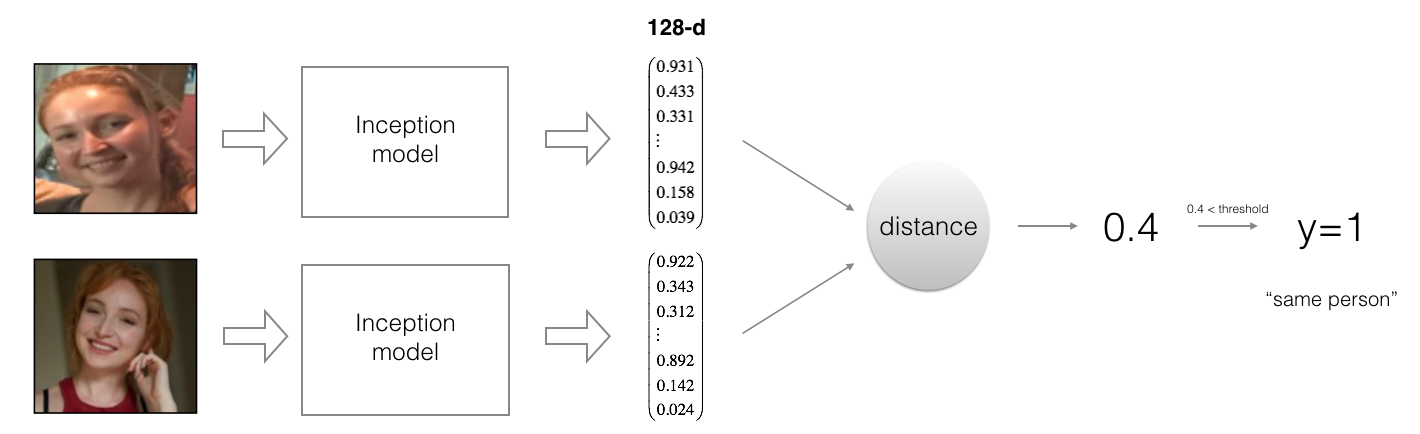


## Triplet Loss Function
For an image $x$, we denote its encoding $f(x)$, where $f$ is the function computed by the neural network.
Training will use triplets of images $(A, P, N)$:

- A is an "Anchor" image--a picture of a person.
- P is a "Positive" image--a picture of the same person as the Anchor image.
- N is a "Negative" image--a picture of a different person than the Anchor image.
These triplets are picked from our training dataset. We will write $(A^{(i)}, P^{(i)}, N^{(i)})$ to denote the $i$-th training example.

To implement the triplet loss :

1. Compute the distance between the encodings of "anchor" and "positive": $\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2$
2. Compute the distance between the encodings of "anchor" and "negative": $\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2$
3. Compute the formula per training example: $ \mid \mid f(A^{(i)}) - f(P^{(i)}) \mid - \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2 + \alpha$
4. Compute the full formula by taking the max with zero and summing over the training examples: $$\mathcal{J} = \sum^{N}_{i=1} \large[ \small \mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2 - \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2+ \alpha \large ] \small_+ \tag{3}$$



In [6]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    ### START CODE HERE ### (≈ 4 lines)
    # Step 1: Compute the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)))
    # Step 2: Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)))
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.maximum(tf.reduce_mean(basic_loss), 0.0)
    ### END CODE HERE ###
    
    return loss

In [7]:
with tf.Session() as test:
    tf.set_random_seed(1)
    y_true = (None, None, None)
    y_pred = (tf.random_normal([3, 128], mean=6, stddev=0.1, seed = 1),
              tf.random_normal([3, 128], mean=1, stddev=1, seed = 1),
              tf.random_normal([3, 128], mean=3, stddev=4, seed = 1))
    loss = triplet_loss(y_true, y_pred)
    
    print("loss = " + str(loss.eval()))

loss = 350.027


# 2 - Loading the trained model
FaceNet is trained by minimizing the triplet loss. But since training requires a lot of data and a lot of computation, we won't train it from scratch here. Instead, we load a previously trained model. Load a model using the following cell.

In [8]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

# Applying the model
Let's apply the model for the purpose of face verification and face recognition.

## Database Generation
Let's build a database containing one encoding vector for each person allowed. To generate the encoding we use img_to_encoding(image_path, model) which basically runs the forward propagation of the model on the specified image.

In [9]:
database = {}
database["danielle"] = img_to_encoding("images/danielle.png", FRmodel)
database["younes"] = img_to_encoding("images/younes.jpg", FRmodel)
database["tian"] = img_to_encoding("images/tian.jpg", FRmodel)
database["andrew"] = img_to_encoding("images/andrew.jpg", FRmodel)
database["kian"] = img_to_encoding("images/kian.jpg", FRmodel)
database["dan"] = img_to_encoding("images/dan.jpg", FRmodel)
database["sebastiano"] = img_to_encoding("images/sebastiano.jpg", FRmodel)
database["bertrand"] = img_to_encoding("images/bertrand.jpg", FRmodel)
database["kevin"] = img_to_encoding("images/kevin.jpg", FRmodel)
database["felix"] = img_to_encoding("images/felix.jpg", FRmodel)
database["benoit"] = img_to_encoding("images/benoit.jpg", FRmodel)
database["arnaud"] = img_to_encoding("images/arnaud.jpg", FRmodel)
database["bhagat"] = img_to_encoding("images/bhagat1.jpg", FRmodel)

## Face Verification
Implement the verify() function which checks if person present is actually the person showing "identity". We will have to go through the following steps:

1. Compute the encoding of the image from image_path
2. Compute the distance about this encoding and the encoding of the identity image stored in the database
3. Open the door if the distance is less than 0.7, else do not open.


In [10]:
def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
    image_path -- path to an image
    identity -- string, name of the person you'd like to verify the identity. Has to be a resident of the Happy house.
    database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
    model -- your Inception model instance in Keras
    
    Returns:
    dist -- distance between the image_path and the image of "identity" in the database.
    door_open -- True, if the door should open. False otherwise.
    """
    
    ### START CODE HERE ###
    
    # Step 1: Compute the encoding for the image. Use img_to_encoding() see example above. (≈ 1 line)
    encoding = img_to_encoding(image_path, model)
    
    # Step 2: Compute distance with identity's image (≈ 1 line)
    dist = np.linalg.norm(encoding-database[identity])
    
    # Step 3: Open the door if dist < 0.7, else don't open (≈ 3 lines)
    if dist < 0.7:
        print("It's " + str(identity) + ", welcome home!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
        
    ### END CODE HERE ###
        
    return dist, door_open

In [11]:
verify("images/camera_0.jpg", "younes", database, FRmodel)

It's younes, welcome home!


(0.67100662, True)

In [12]:
verify("images/camera_0.jpg", "kian", database, FRmodel)

It's not kian, please go away


(0.85842526, False)

## Face Recognition
We'll implement a face recognition system that takes as input an image, and figures out if it is one of the authorized persons (and if so, who). Unlike the previous face verification system, we will no longer get a person's identity as another input.

Exercise: Implement who_is_it(). we will have to go through the following steps:

1. Compute the target encoding of the image from image_path
2. Find the encoding from the database that has smallest distance with the target encoding.
3. Initialize the min_dist variable to a large enough number (100). It will help us keep track of what is the closest encoding to the input's encoding.
4. Loop over the database dictionary's names and encodings. To loop use for (name, db_enc) in database.items().
5. Compute L2 distance between the target "encoding" and the current "encoding" from the database.
<br/>If this distance is less than the min_dist, then set min_dist to dist, and identity to name.

In [13]:
def who_is_it(image_path, database, model):
    """
    Implements face recognition for the happy house by finding who is the person on the image_path image.
    
    Arguments:
    image_path -- path to an image
    database -- database containing image encodings along with the name of the person on the image
    model -- your Inception model instance in Keras
    
    Returns:
    min_dist -- the minimum distance between image_path encoding and the encodings from the database
    identity -- string, the name prediction for the person on image_path
    """
    
    ### START CODE HERE ### 
    
    ## Step 1: Compute the target "encoding" for the image. Use img_to_encoding() see example above. ## (≈ 1 line)
    encoding = img_to_encoding(image_path, model)
    
    ## Step 2: Find the closest encoding ##
    
    # Initialize "min_dist" to a large value, say 100 (≈1 line)
    min_dist = 100
    
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current "emb" from the database. (≈ 1 line)
        dist = np.linalg.norm(encoding-db_enc)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. (≈ 3 lines)
        if dist < min_dist:
            min_dist = dist
            identity = name

    ### END CODE HERE ###
    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity


In [14]:
who_is_it("images/camera_0.jpg", database, FRmodel)

it's younes, the distance is 0.671007


(0.67100662, 'younes')

# References:
Florian Schroff, Dmitry Kalenichenko, James Philbin (2015).<a href="https://arxiv.org/pdf/1503.03832.pdf">FaceNet: A Unified Embedding for Face Recognition and Clustering</a> <br/>

Yaniv Taigman, Ming Yang, Marc'Aurelio Ranzato, Lior Wolf (2014)<a href="https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf">DeepFace: Closing the gap to human-level performance in face verification</a> <br/>